In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [317]:
image = cv2.imread("../gg.jpg",0)

In [318]:
def show(image):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image,cmap="gray")

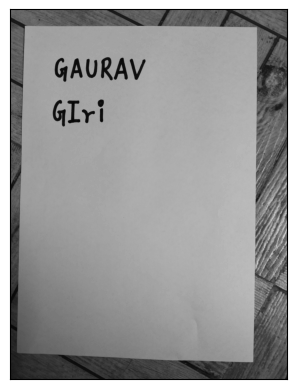

In [319]:
show(image)

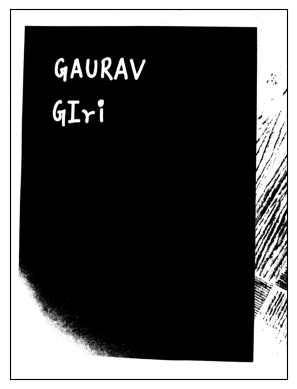

In [320]:
binarized_image = image.copy()
_, binarized_image = cv2.threshold(binarized_image,thresh=0,maxval=255,type=cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    # binarized_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

show(binarized_image)

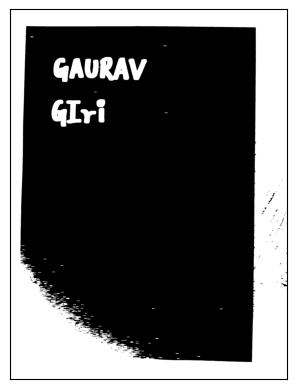

In [321]:
# Define kernel for morphological operations
line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
word_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
character_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (1, 2))

dilated_image = cv2.dilate(binarized_image, line_kernel, iterations=2)
show(dilated_image)

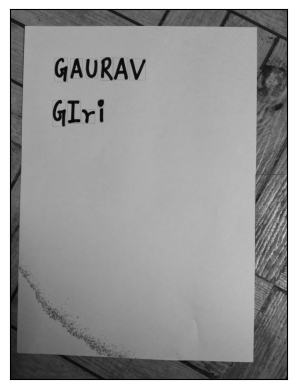

In [322]:
# Create a copy of the original image
bounding_image = image.copy()

segmented_image_list = []

# Dilate the image to connect nearby characters into lines
line_dilated = cv2.dilate(binarized_image, line_kernel, iterations=2)

# Find contours of lines
line_contours, _ = cv2.findContours(line_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on their y-coordinate
line_sorted_contours = sorted(line_contours, key=lambda cnt: cv2.boundingRect(cnt)[1])

# Loop over each line contour
for line_cnt in line_sorted_contours:
    lx, ly, lw, lh = cv2.boundingRect(line_cnt)
    
    # Extract the line from the binarized image
    line = binarized_image[ly:ly+lh, lx:lx+lw]

    # List to hold word images in this line
    word_images = []
    
    # Dilate the line to connect nearby characters into words
    word_dilated = cv2.dilate(line, word_kernel, iterations=1)
    
    # Find contours of words
    word_contours, _ = cv2.findContours(word_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours based on their x-coordinate
    word_sorted_contours = sorted(word_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    # Loop over each word contour
    for word_cnt in word_sorted_contours:
        wx, wy, ww, wh = cv2.boundingRect(word_cnt)

        # Extract the word from the line
        word = line[wy:wy+wh, wx:wx+ww]

        # List to hold character images in this word
        character_images = []
        
        # Open gaps within characters
        character_open = cv2.morphologyEx(word, cv2.MORPH_OPEN, character_kernel, iterations=1)
        
        # Find contours of characters
        character_contours, _ = cv2.findContours(character_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort contours based on their x-coordinate
        character_sorted_contours = sorted(character_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

        # Loop over each character contour
        for character_cnt in character_sorted_contours:
            cx, cy, cw, ch = cv2.boundingRect(character_cnt)
            # Extract the character from the word
            character = word[cy:cy+ch+4, cx:cx+cw+4]
            # Add character image to the list
            character_images.append(character)
            
            # Draw rectangle around the character on the bounding image
            cv2.rectangle(bounding_image, (lx+wx+cx, ly+wy+cy), (lx+wx+cx+cw, ly+wy+cy+ch), (0, 255, 0), 1)
        
        # Add list of character images to word images list
        word_images.append(character_images)
    
    # Add list of word images to line images list
    segmented_image_list.append(word_images)

show(bounding_image)
